In [1]:
'''
=========================================================================
OSE bootcamp 2019
Week 5, [ Tony Smith's lecture ]
Problem Set: Heterogeneous Agent Models
[ Based on Aiyagari(1994) ]

By Dohan Kim (UPenn), 2019 August
=========================================================================
'''

import numpy as np
import sympy as sy
from matplotlib import pyplot as plt
from matplotlib import rc
from mpl_toolkits import mplot3d
import quantecon as qe
from quantecon.optimize.scalar_maximization import brent_max
from scipy.optimize import brentq, newton
from scipy.optimize import fsolve
from numba import njit
import time
from numpy import linalg as LA
import numpy.matlib
from bisect import bisect
import sys

In [2]:
# Parameters
β = 0.96   # discount factor
δ = 0.06   # capital depreciation rate
α = 0.36   # capital share parameter of the Cobb-Douglas production function
γ = 1      # utiliby function : u(c) = (c^(1-γ) - 1) / (1 - γ)

params = (β, δ, α, γ)

# given values  
p22 = 0.9   # a probability of remaining employed next period conditional on being employed today
ubar = 0.1  # steady state unemployed rate
nk = 200    # a number of points for capital
nϵ = 2      # a number of points for idiosyncratic shock

In [3]:
def transition_prob(p22, ubar):
    '''
    This function computes the transition probabilities
    (state 0: unemployed, state 1: employed)
    
    [ Parameters ]
        p22  : a prabability of remaning employed next period conditional on beging employed today
        ubar : steady state unempolyed rate
    
    [ Return ]
        P : the transition matrix (nϵ) by (nϵ) [p11, p12; p21 p22]
    '''
    
    p11 = (2-p22) + (p22-1)/ubar
    P = np.zeros((2,2))
    P[0,0] = p11
    P[0,1] = 1-p11
    P[1,0] = 1-p22
    P[1,1] = p22

    return P

P = transition_prob(0.9, 0.1)
print("The transition matrix = ")
print(np.round(P,2))

The transition matrix = 
[[0.1 0.9]
 [0.1 0.9]]


In [4]:
#--------------------------- 
# Value Function Iteration
#---------------------------

def VFI(Kbar, u, kgrid, ϵgrid, P, params, Max_Iter=1000, tol=1e-5, seeIter=50):
    '''
    This function implements the value function iteration given Kbar.

    [ Parameters ]
        Kbar     : aggregate steady state capital
        u        : steady state unemployment rate
        kgrid    : capital grid
        ϵgrid    : idiosyncratic shock grid
        P        : transition matrix
        params   : β, δ, α, γ
        Max_Iter : the maximum number of iteration (default = 1000)
        tol      : a tolerance level (default = 1e-5)
        seeIter  : show the difference per "seeIter" iterations ('0' : do not show)

    [ Return ]
        mV    : the value function V(k,ϵ)
        mPk   : the optimal capital choice k(k,ϵ)
    '''
    #--------
    # Set up
    #--------
    
    β, δ, α, γ = params
    nk = len(kgrid)
    nϵ = len(ϵgrid)
    
    # required matrices and vectors
    mV = np.zeros((nk, nϵ))   # save values for value function : V(k,ϵ)
    mPk = np.zeros_like(mV)   # save optimal capital choice : k(k,ϵ)
    
    # compute prices given Kbar
    rK = α*(Kbar**(α-1)) * ((1-u)**(1-α))
    wK = (1-α) * (Kbar**α) * ((1-u)**(-α))
    
    @njit
    def compute_value(kp, k, iϵ, mV):
        '''
        This function computes values for the value function

        [ Parameters ]
            kp : capital choice for tomorrow
            k  : today's capital stock
            iϵ : the current shock index (employment status)
            mV : the value function v(k,ϵ)
        
        [ Return ]
            value : the value for value function
        '''
        
        eV = np.zeros(nϵ)
        
        for iϵp in range(nϵ):
            if kp <= kgrid[nk-1]:
                eV[iϵp] = np.interp(kp, kgrid, mV[:,iϵp])
            else:
                eV[iϵp] = mV[nk-2,iϵp] + (kp-kgrid[nk-2])/(kgrid[nk-1]-kgrid[nk-2]) \
                    * (mV[nk-1,iϵp]-mV[nk-2,iϵp])
            
        cons = rK*k + wK*ϵgrid[iϵ] + (1-δ)*k - kp
        
        if cons <= 0:
            value = -1e+10
        else:
            if γ == 1:
                value = np.log(cons) + β*np.dot(eV, P[iϵ,:])
            else:
                value = ((cons**(1-γ) - 1) / (1 - γ)) + β*np.dot(eV, P[iϵ,:])
            
        return value
    
    @njit
    def BellmanOperator(mV):
        '''
        The Bellman operator
        
        [ Parameter ]
            mV  : the current value function V(k,ϵ)
            
        [ Returns ]
            mVnew : the new value function V(k,ϵ)
            mPk   : the optimal capital choice k(k,ϵ)
        '''

        mVnew = np.zeros_like(mV) # mVnew = T(mV)
        mPk = np.zeros_like(mV)   # save optimal capital choice k(k,ϵ)
        
        for ik in range(nk):
            k = kgrid[ik]       
            for iϵ in range(nϵ):
                ϵ = ϵgrid[iϵ]
                kmax = rK*k + wK*ϵ + (1-δ)*k
                result = brent_max(compute_value, 1e-10, kmax, args=(k, iϵ, mV))
                mVnew[ik,iϵ] = result[1]
                mPk[ik,iϵ] = result[0]
                
        return (mVnew, mPk)
    
    #------------
    # Iteration
    #------------
    
    diff = 10
    it = 0

    while (diff > tol) and (it < Max_Iter):
        
        it += 1
        mVnew, mPk = BellmanOperator(mV)
        
        diff = np.max(np.abs(mV - mVnew))
        mV = mVnew
        
        if seeIter != 0:
            if (it % seeIter == 0) or (it == 1):
                print("   Iteration: %4d,   the maximum difference: %8.6f" % (it, diff))
        
    if seeIter != 0:
        if it % seeIter != 0:
            print("   Iteration: %4d,   the maximum difference: %6.5ef" % (it, diff))

    return (mV, mPk) 

In [5]:
def transition_matrix(kgrid, ϵgrid, P, mPk):
    '''
    This function computes the transition matrix
        
    [ Parameters ]
        kgrid : capital grid
        ϵgrid : idiosyncratic shock grid
        P     : the Markov chain for ϵ
        mPk   : the optimal capital choice k(k,ϵ)
        
    [ Returns ]
        mT : the transition matrix (nk*nϵ) by (nk*nϵ)
    '''
    
    nk = len(kgrid)
    nϵ = len(ϵgrid)
    
    # construct the decision rule for capital (k)
    mT = np.zeros((nk*nϵ, nk*nϵ))
   
    for ik in range(nk):
        for iϵ in range(nϵ):
            kp = mPk[ik,iϵ]
            index = np.searchsorted(kgrid, kp)
            if index >= nk:
                mT[ik*nϵ+iϵ, (nk-1)*nϵ:nk*nϵ] += 1
            elif index == 0:
                mT[ik*nϵ+iϵ, :nϵ] += 1
            else:
                prob = (kp - kgrid[index-1]) / (kgrid[index] - kgrid[index-1])
                mT[ik*nϵ+iϵ, index*nϵ:(index+1)*nϵ] += prob
                mT[ik*nϵ+iϵ, (index-1)*nϵ:index*nϵ] += 1 - prob
                
    mT = np.multiply(mT, np.matlib.repmat(P, nk, nk))
    
    # check if the sum of probability for each row is 1
    for i in range(nk*nϵ):
        if np.abs(np.sum(mT[i,:]) - 1.0) > 1e-10:
            print("The sum of probability is not 1.0 but %4.2f for %d row" % (np.sum(mT[i,:]),i))
    
    return mT

In [6]:
def StationaryDist(T):
    ''' 
    This function computes the stationary distribution g(k,ϵ)
    g = gT where x is the answer
    g - gT = 0
    g( I - T ) = 0 and sum(g) = 1
    
    [ Parameter ]
        T : the Markov chain
        
    [ Return ]
        g : the stationary distribution
    '''
    
    n = T.shape[0]
    a = np.eye(n) - T
    a = np.vstack((a.T, np.ones(n)))
    b = np.matrix([0]*n + [1]).T
    dist = np.linalg.lstsq(a, b, rcond=-1)[0]
    g = np.squeeze(np.asarray(dist))
    
    return g

In [7]:
def capital_market_clear(Kbar, u, kgrid, ϵgrid, P, params):
    '''
    This function checks the capital market clearing condition (i.e., Ks = Kd)
        
    [ Parameters ]
        Kbar   : aggregate steady state capital (capital demand, Kd)
        u      : steady state unemployment rate
        kgrid  : capital grid
        ϵgrid  : idiosyncratic shock grid
        P      : transition matrix
        params : β, δ, α, γ
        
    [ Returns ]
        K - Kbar : capital supply(K=Ks) - capital demand(Kbar=Kd)
    '''
    
    mV, mPk = VFI(Kbar, u, kgrid, ϵgrid, P, params, Max_Iter=1000, tol=1e-5, seeIter=0)
    mT = transition_matrix(kgrid, ϵgrid, P, mPk)
    g_dist = StationaryDist(mT)
    g_dist = np.reshape(g_dist, (nk,nϵ))
    K = np.sum(np.multiply(mPk, g_dist))
    
    return K - Kbar

In [8]:
kgrid = np.linspace(0.001, 40, nk)
ϵgrid = np.linspace(0, 1, nϵ)

# compute the steady state capital stock Kbar*
start = time.time()
Kstar = brentq(capital_market_clear, kgrid[0], kgrid[nk-1], args=(ubar, kgrid, ϵgrid, P, params))
print("%s = %4.4f" % ('K\u0304*',Kstar))
end = time.time()
print("Elapsed = %4.2f seconds" % (end - start))

K̄* = 6.5608
Elapsed = 46.71 seconds


   Iteration:    1,   the maximum difference: 6.872549
   Iteration:  100,   the maximum difference: 0.007669
   Iteration:  200,   the maximum difference: 0.000129
   Iteration:  265,   the maximum difference: 9.69932e-06f


Text(0, 0.5, "k'")

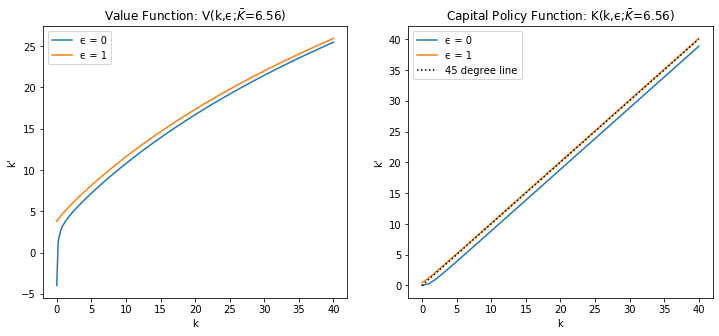

In [9]:
mV, mPk = VFI(Kstar, ubar, kgrid, ϵgrid, P, params, Max_Iter=1000, tol=1e-5, seeIter=100)

fig1 = plt.figure(figsize = [12, 5])
    
# Plot the value function V(k,ϵ;Kbar)
VF = fig1.add_subplot(1, 2, 1)
for iϵ in range(nϵ):
    plt.plot(kgrid, mV[:,iϵ])
plt.title("Value Function: V(k,ϵ;"r'$\bar{K}$=%2.2f)' % Kstar)
plt.legend(['ϵ = 0', 'ϵ = 1'])
plt.xlabel("k")
plt.ylabel("k'")

# Plot the policy function K(k,ϵ;Kbar)
VF = fig1.add_subplot(1, 2, 2)
for iϵ in range(nϵ):
    plt.plot(kgrid, mPk[:,iϵ], label=("ϵ = %d" % ϵgrid[iϵ]))
plt.plot(kgrid, kgrid, ':', color='black', label="45 degree line")
plt.title("Capital Policy Function: K(k,ϵ;"r'$\bar{K}$=%2.2f)' % Kstar)
plt.legend()
plt.xlabel("k")
plt.ylabel("k'")

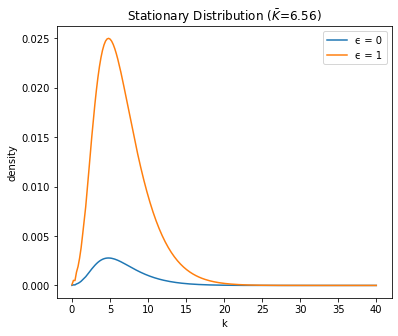

In [10]:
mT = transition_matrix(kgrid, ϵgrid, P, mPk)
g_dist = StationaryDist(mT)
g_dist = np.reshape(g_dist, (nk,nϵ))

# Plot the stationary distribution g(k,ϵ;Kbar*)

fig2 = plt.figure(figsize = [6, 5])

fig2.add_subplot(111)
for iϵ in range(nϵ):
    plt.plot(kgrid, g_dist[:,iϵ], label=("ϵ = %d" % ϵgrid[iϵ]))
plt.title("Stationary Distribution ("r'$\bar{K}$=%2.2f)' % Kstar)
plt.legend()
plt.xlabel("k")
plt.ylabel("density")
plt.show()

In [11]:
def compute_rss(K):
    rss = α*(K**(α-1)) * ((1-ubar)**(1-α))
    return rss

Kss_rep = ((1-β*(1-δ)) / (α*β*(1-ubar)**(1-α)))**(1/(α-1))

rss_het = compute_rss(Kstar) * 100
rss_rep = compute_rss(Kss_rep) * 100

print("[ the steady state interest rate (r)]")
print("")
print("in the representative agent model : %4.3f " % rss_rep, "%")
print("in the heterogeneous agent model  : %4.3f " % rss_het, "%")

[ the steady state interest rate (r)]

in the representative agent model : 10.167  %
in the heterogeneous agent model  : 10.096  %


### End